<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_clustering_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.9 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification

In [3]:
import numpy as np
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/NIH/Data/"

Mounted at /content/drive


load file

In [5]:
notes_name = 'NOTES_NURSING_TRAJECTORIES_sentimentchange_multipleCG_patient_data.csv'
df_notes = pd.read_csv(file_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CGID                  53 non-null     int64  
 1   SUBJECT_ID            53 non-null     int64  
 2   emb_distance          53 non-null     object 
 3   attitudes             53 non-null     object 
 4   attitudes_char        53 non-null     object 
 5   Sentiment_Change      53 non-null     object 
 6   ROW_ID                53 non-null     int64  
 7   HADM_ID               53 non-null     int64  
 8   ADMITTIME             53 non-null     object 
 9   DISCHTIME             53 non-null     object 
 10  DEATHTIME             0 non-null      float64
 11  ADMISSION_TYPE        53 non-null     object 
 12  ADMISSION_LOCATION    53 non-null     object 
 13  DISCHARGE_LOCATION    53 non-null     object 
 14  INSURANCE             53 non-null     object 
 15  LANGUAGE              4 n

pre-processing

In [6]:
cgid = 17400
df_cg = df_notes[df_notes['CGID']==cgid].drop(['MARITAL_STATUS','EDREGTIME','EDOUTTIME','HAS_CHARTEVENTS_DATA','DEATHTIME'],axis=1)
df_cg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 16 to 21
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CGID                  6 non-null      int64 
 1   SUBJECT_ID            6 non-null      int64 
 2   emb_distance          6 non-null      object
 3   attitudes             6 non-null      object
 4   attitudes_char        6 non-null      object
 5   Sentiment_Change      6 non-null      object
 6   ROW_ID                6 non-null      int64 
 7   HADM_ID               6 non-null      int64 
 8   ADMITTIME             6 non-null      object
 9   DISCHTIME             6 non-null      object
 10  ADMISSION_TYPE        6 non-null      object
 11  ADMISSION_LOCATION    6 non-null      object
 12  DISCHARGE_LOCATION    6 non-null      object
 13  INSURANCE             6 non-null      object
 14  LANGUAGE              1 non-null      object
 15  RELIGION              6 non-null      obje

In [7]:
df_cg

,CGID,SUBJECT_ID,emb_distance,attitudes,attitudes_char,Sentiment_Change,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
16,17400,18946,"[0.5782564878463745, 0.8767606019973755, 0.872...","['Overall Neutral Note', 'Overall Neutral Note...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",23101,160113,2148-09-20 12:23:00,2148-12-12 18:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,NaN,NOT SPECIFIED,WHITE,NEWBORN,0
17,17400,2024,"[0.863370954990387, 0.721912145614624, 0.81382...","['Overall Neutral Note', 'Overall Neutral Note...","[0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",2447,114511,2117-11-28 21:38:00,2118-01-10 15:30:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Private,RUSS,UNOBTAINABLE,WHITE,NEWBORN,0
18,17400,15482,"[0.7051495313644409, 0.844388484954834, 0.8481...","['Overall Neutral Note', 'Overall Neutral Note...","[0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",18913,178068,2124-10-25 11:48:00,2125-02-20 13:45:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Private,NaN,JEWISH,WHITE,NEWBORN,0
19,17400,17503,"[0.8604238033294678, 0.8683540225028992, 0.757...","['Overall Neutral Note', 'Overall Neutral Note...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21382,142226,2171-09-27 12:21:00,2171-11-04 14:00:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Private,NaN,NOT SPECIFIED,WHITE,NEWBORN,0
20,17400,16842,"[0.8710215091705322, 0.7890030145645142, 0.754...","['Overall Neutral Note', 'Overall Neutral Note...","[0, 0, 0, 0, 0, 0, -1, 0, 0]","[0, 0, 0, 0, 0, 1, 1, 0]",20588,119731,2145-11-01 17:53:00,2145-11-15 14:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,SHORT TERM HOSPITAL,Private,NaN,UNOBTAINABLE,WHITE,NEWBORN,0
21,17400,4253,"[0.8926266431808472, 0.9165804386138916, 0.363...","['Overall Neutral Note', 'Overall Neutral Note...","[0, 0, 0, -1, 0, 0, 0]","[0, 0, 1, 1, 0, 0]",5151,149112,2101-03-20 15:58:00,2101-03-30 15:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,NEWBORN,0


In [8]:
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes_neonat = pd.read_csv(file_path+notes_name)

In [9]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
def create_embeddings(list_of_sentences):  
  encoded_input = tokenizer(list_of_sentences, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    model_output = model(**encoded_input)
  token_embeddings = model_output.last_hidden_state  

  def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

  # Perform pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

  # Normalize embeddings
  sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

  sentence_embeddings_np = sentence_embeddings.detach().numpy()

  return sentence_embeddings_np

In [10]:
sub_dic = {}
subid = 7337
df_cg['notes_embeddings']=None
for subid in df_cg['SUBJECT_ID']:
  condition = (df_notes_neonat['CGID'] == cgid) & (df_notes_neonat['SUBJECT_ID'] == subid)
  sentences = df_notes_neonat[condition].sort_values(by='CHARTDATE')['TEXT'].tolist()
  sub_dic[subid] = sentences

In [11]:
data = []
data.extend([create_embeddings(item) for item in sub_dic.values()])

In [12]:
all_embs_data = []
for item in data: 
  for sub_item in item:
    all_embs_data.append(sub_item)

In [13]:
embeddings = np.array(all_embs_data)
embeddings.shape

(88, 384)

In [14]:
import json


In [60]:
colors = []
sentiment = []
data = []
for k, v in sub_dic.items():
  sub_row = df_cg[df_cg['SUBJECT_ID']==k]
  l = json.loads(df_cg[df_cg['SUBJECT_ID']==k]['attitudes_char'].iloc[0])
  for _ in v:
    colors.append(k)
    data.append(('ETHNICITY:'+sub_row['ETHNICITY'].values[0],'INSURANCE:'+sub_row['INSURANCE'].values[0]))
  for s in l: 
    sentiment.append(s)
  

In [59]:
data

[('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPrivate'),
 ('ETHNICITY:WHITE', 'INSURANCEPri

In [61]:
sent_dic = {-1:70, 0:10, 1:70}

In [62]:
id_dic = {item:idx for idx,item in enumerate(set(colors))}

In [64]:
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA
reduced_data = PCA(n_components=50).fit_transform(embeddings)


tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(reduced_data)

fig = px.scatter(
    projections, x=0,y =1,
    size=[sent_dic[item] for item in sentiment],
    color=[id_dic[item] for item in colors],
    hover_name=["subject "+str(id_dic[item]) for item in colors],
    hover_data=[data,],
    symbol = sentiment, labels={'color':'subject_id', 'symbol': 'sentiment'}
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

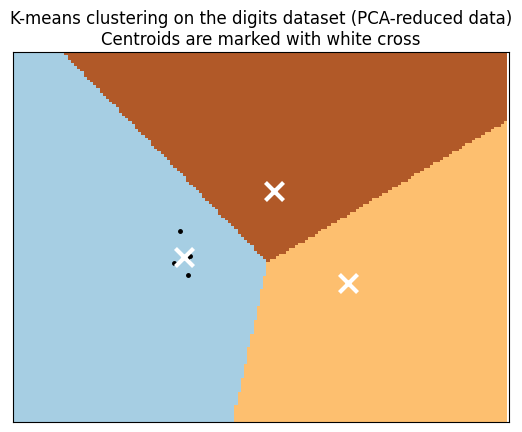

In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()].astype('float32'))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()